### 1. Trying out sentiment analysis models

In [1]:
from transformers import TFRobertaForSequenceClassification
from transformers import TFAutoModelForSequenceClassification
from transformers import AutoTokenizer, AutoConfig
import numpy as np
from scipy.special import softmax
import logging
from transformers import logging as transformers_logging
import pandas as pd
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt


transformers_logging.set_verbosity_error()
logging.getLogger("transformers").setLevel(logging.ERROR)

labels = {
    0 : 'negative',
    1 : 'neutral',
    2 : 'positive'
}
def test_sentiment_score(text, tokenizer, model):
    encoded_input = tokenizer(text, return_tensors='tf')
    output = model(encoded_input)
    scores = output[0][0].numpy()
    scores = softmax(scores)
    ranking = np.argsort(scores)
    ranking = ranking[::-1]
    ranked_labels = [labels[i] for i in ranking]
    return (ranked_labels[0])

def test_sentiment_score_raw(text, tokenizer, model):
    encoded_input = tokenizer(text, return_tensors = 'tf')
    output = model(encoded_input)
    scores = output[0][0].numpy()
    scores = softmax(scores)
    return scores

def test_sentiment_score_transformed(text, tokenizer, model):
    encoded_input = tokenizer(text, return_tensors='tf')
    output = model(encoded_input)
    scores = output[0].numpy()
    scores = softmax(scores, axis=1)
    sentiment_scores = scores[:, 2] - scores[:, 0]
    return sentiment_scores.tolist()

In [2]:
import re
 
text = "Lufthansa lost my luggage"
model_roberta_latest = "cardiffnlp/twitter-roberta-base-sentiment-latest"
model_roberta_xlm = "cardiffnlp/twitter-xlm-roberta-base-sentiment"
model_roberta_older = "cardiffnlp/twitter-roberta-base-sentiment"
model_name_bertweet = "finiteautomata/bertweet-base-sentiment-analysis"

tokenizer_xlm = AutoTokenizer.from_pretrained(model_roberta_xlm)
model_xlm = TFRobertaForSequenceClassification.from_pretrained(model_roberta_xlm)

sentiment_score_xlm = test_sentiment_score(text, tokenizer_xlm, model_xlm)
sentiment_score_xlm_raw = test_sentiment_score_raw(text, tokenizer_xlm, model_xlm)
sentiment_score_xlm_transformed = test_sentiment_score_transformed(text, tokenizer_xlm, model_xlm)


#print(f"Sentiment score ({re.search(r'[^/]+$', model_roberta_xlm).group(0)}): {sentiment_score_xlm}")
print(f"Model:({re.search(r'[^/]+$', model_roberta_xlm).group(0)}), tweet: ({text}), score: ({sentiment_score_xlm_raw}), label: ({sentiment_score_xlm})")
print(f"Model:({re.search(r'[^/]+$', model_roberta_xlm).group(0)}), tweet: ({text}), score: ({sentiment_score_xlm_transformed}), label: ({sentiment_score_xlm})")


c:\My programs\Python 3.12\Lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(



Model:(twitter-xlm-roberta-base-sentiment), tweet: (Lufthansa lost my luggage), score: ([0.8112228  0.16683333 0.02194384]), label: (negative)
Model:(twitter-xlm-roberta-base-sentiment), tweet: (Lufthansa lost my luggage), score: ([-0.7892789840698242]), label: (negative)


In [3]:
### 2. Setting up dataframe for accuracy calculation

In [4]:

df_test = pd.read_csv('Tweets.csv')
df_test.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [5]:

df_test = df_test.head(1000) #Only doing this on the first 1000 tweets, to save time

In [6]:
pd.set_option('display.max_colwidth', None)  
df_test['roberta_xlm'] = df_test['text'].apply(lambda x: test_sentiment_score(x, tokenizer_xlm, model_xlm))

df_test

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone,roberta_xlm
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada),neutral
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials to the experience... tacky.,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada),negative
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I need to take another trip!,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada),negative
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,"@VirginAmerica it's really aggressive to blast obnoxious ""entertainment"" in your guests' faces &amp; they have little recourse",NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada),negative
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing about it,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada),negative
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,569970938525016065,negative,1.0000,Late Flight,0.7065,United,NaN,tbird12lv,NaN,0,@united by the time I finally get to Dallas I could have driven with less frustration and cheaper.,NaN,2015-02-23 13:23:55 -0800,Colorado,Mountain Time (US & Canada),neutral
996,569970599377788928,negative,1.0000,Late Flight,1.0000,United,NaN,cristobalwong,NaN,0,"@united I'm trying to get to my final destination, we need compensation. Just about 2hrs of personal time wasted.",NaN,2015-02-23 13:22:35 -0800,San Francisco Bay Area,NaN,negative
997,569970225443172353,negative,1.0000,Customer Service Issue,0.6667,United,NaN,itsmetsforme,NaN,0,@united that guy really has no customer service clue.Could have spent effort clearing bins for rollerboards instead of art projects in mine!,NaN,2015-02-23 13:21:05 -0800,mets hell,NaN,negative
998,569969999961391105,positive,0.6915,NaN,NaN,United,NaN,swampynomo,NaN,0,@united he has no priority and Iove it,NaN,2015-02-23 13:20:12 -0800,NJ/NYC,Eastern Time (US & Canada),positive


### 3. Checking the accuracy by comparing model labels with human labels (on 100 first tweets)

In [7]:
matches = df_test['airline_sentiment'] == df_test['roberta_xlm']
percentage_matches = matches.mean() * 100
print(f"Accuracy of roberta_xlm model: {percentage_matches:.2f}%")

Accuracy of roberta_xlm model: 75.10%


In [8]:
df_test[["text", "airline_sentiment", "roberta_xlm"]].query("airline_sentiment == 'positive' and roberta_xlm == 'negative'").head(20)

,text,airline_sentiment,roberta_xlm
1,@VirginAmerica plus you've added commercials to the experience... tacky.,positive,negative
114,@VirginAmerica come back to #PHL already. We need you to take us out of this horrible cold. #pleasecomeback http://t.co/gLXFwP6nQH,positive,negative
233,"@VirginAmerica, the only airline based in Silicon Valley! #disruption #FCmostinnovative #incubator @FastCompany's http://t.co/wU3LbCNcr9",positive,negative
307,"@VirginAmerica I mean. Probably inappropriate while on board.. But, it's on!",positive,negative
375,@VirginAmerica Flight Booking Problems last second flight for next week from SFO- to SAN any chance you want to gift me a promo code since I love you guys,positive,negative
552,"@united - thanks for your help...got me what I need, but its an issue with @_austrian . I guess I sit awhile longer.",positive,negative
663,@united private jet would have been cool! Do does not work. I'll try again,positive,negative


In [11]:
df_test.to_csv("sentiment_accuracy.csv")

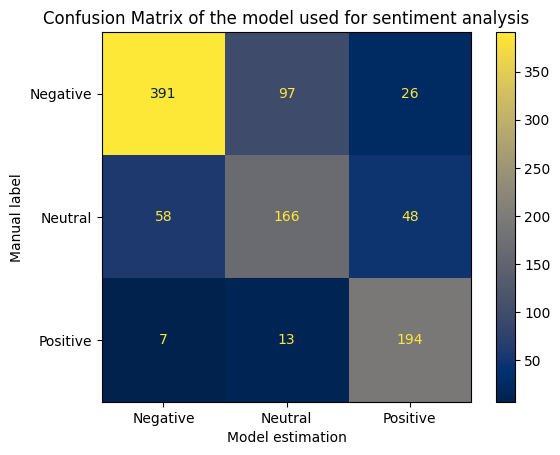

In [9]:
# Extract true sentiment and predicted sentiment
y_true = df_test['airline_sentiment']
y_pred = df_test['roberta_xlm']

# Compute the confusion matrix
cm = confusion_matrix(y_true, y_pred, labels=['negative', 'neutral', 'positive'])

# Create a confusion matrix display
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Negative', 'Neutral', 'Positive'])

# Plot the confusion matrix
disp.plot(cmap='cividis')
plt.ylabel('Manual label')
plt.xlabel('Model estimation')
plt.title('Confusion Matrix of the model used for sentiment analysis');